In [1]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import matplotlib.pyplot as plt

In [2]:
# Load the FinBERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone')

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

C:\Users\vskar\OneDrive\Documents\stockprice_project\my_new_env\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\vskar\.cache\huggingface\hub\models--yiyanghkust--finbert-tone. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [3]:
# Initialize a sentiment analysis pipeline
finbert_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [4]:
# Load the dataset
try:
    news = pd.read_csv('abcnews-date-text.csv')
except FileNotFoundError:
    print("Dataset not found. Please check the file path.")

In [5]:
# Display basic information about the dataset
print("Dataset Info:")
news.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244184 entries, 0 to 1244183
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   publish_date   1244184 non-null  int64 
 1   headline_text  1244184 non-null  object
dtypes: int64(1), object(1)
memory usage: 19.0+ MB


In [6]:
# Quick look at the first few rows
print("\nFirst few rows of the dataset:")
news.head()


First few rows of the dataset:
   publish_date                                      headline_text
0      20030219  aba decides against community broadcasting lic...
1      20030219     act fire witnesses must be aware of defamation
2      20030219     a g calls for infrastructure protection summit
3      20030219           air nz staff in aust strike for pay rise
4      20030219      air nz strike to affect australian travellers


In [7]:
# Check for missing values
print("\nMissing values in each column:")
print(news.isnull().sum())


Missing values in each column:
publish_date     0
headline_text    0
dtype: int64


In [8]:
# Check for duplicates
print("\nTotal number of duplicate rows:")
news.duplicated().sum()


Total number of duplicate rows:
2


In [9]:
# Drop duplicates if any
news.drop_duplicates(inplace=True, ignore_index=True)
print("\nData after dropping duplicates:")
news.info()


Data after dropping duplicates:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244182 entries, 0 to 1244181
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   publish_date   1244182 non-null  int64 
 1   headline_text  1244182 non-null  object
dtypes: int64(1), object(1)
memory usage: 19.0+ MB
None


In [10]:
# Check the unique values in 'headline_text'
print("\nUnique headlines count:")
news['headline_text'].nunique()


Unique headlines count:
1213004


In [11]:
# Handle missing values in 'headline_text' by dropping rows where 'headline_text' is NaN
news.dropna(subset=['headline_text'], inplace=True)
print("\nData after handling missing 'headline_text' values:")
news.info()


Data after handling missing 'headline_text' values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244182 entries, 0 to 1244181
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   publish_date   1244182 non-null  int64 
 1   headline_text  1244182 non-null  object
dtypes: int64(1), object(1)
memory usage: 19.0+ MB


In [12]:
# Convert 'publish_date' to datetime
news['publish_date'] = pd.to_datetime(news['publish_date'], format='%Y%m%d')
print("\nData after converting 'publish_date' to datetime:")
news.info()


Data after converting 'publish_date' to datetime:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244182 entries, 0 to 1244181
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   publish_date   1244182 non-null  datetime64[ns]
 1   headline_text  1244182 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 19.0+ MB


In [13]:
# Exploratory Data Analysis: Top 5 headlines by frequency
print("\nTop 5 most frequent headlines:")
news['headline_text'].value_counts().head()


Top 5 most frequent headlines:


headline_text
national rural news                      983
abc sport                                718
abc weather                              714
abc business news and market analysis    585
abc entertainment                        551
Name: count, dtype: int64

In [14]:
# Filter for business-related news headlines and create a copy
business_news = news[news['headline_text'].str.contains('business|market|finance|stocks|economy|investment|trading', case=False)].copy()

In [15]:
# Perform sentiment analysis using FinBERT
def analyze_sentiment(text):
    result = finbert_pipeline(text)
    return result[0]['label'], result[0]['score']

In [17]:
business_news['sentiment_label'], business_news['sentiment_score'] = zip(*business_news['headline_text'].apply(analyze_sentiment))

In [18]:
# Display the first few rows after sentiment analysis
print("\nBusiness news data with FinBERT sentiment analysis:")
print(business_news[['headline_text', 'sentiment_label', 'sentiment_score']].head())


Business news data with FinBERT sentiment analysis:
                                       headline_text sentiment_label  \
20   businesses should prepare for terrorist attacks         Neutral   
151                   resource stocks boost all ords        Positive   
163            shire offers assurances over finances         Neutral   
165         slow recovery predicted for aust economy        Negative   
341                    mud crab business on the move         Neutral   

     sentiment_score  
20          0.783112  
151         1.000000  
163         0.873707  
165         0.999993  
341         0.999142  


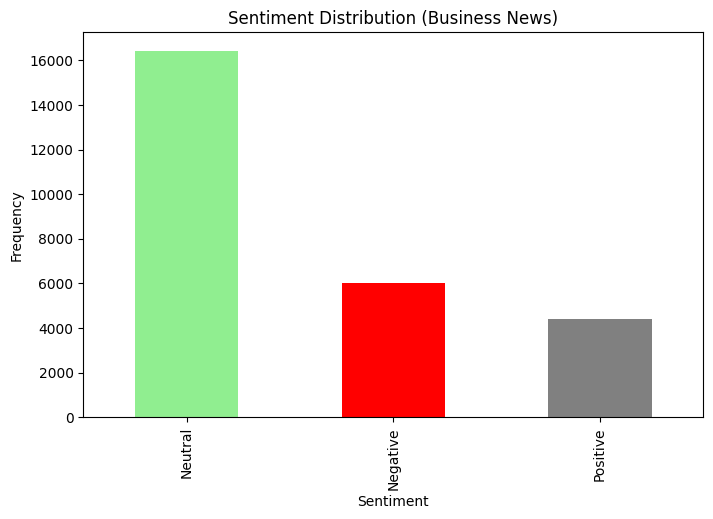

In [19]:
# Visualize sentiment distribution for business news
plt.figure(figsize=(8, 5))
business_news['sentiment_label'].value_counts().plot(kind='bar', color=['lightgreen', 'red', 'gray'])
plt.title('Sentiment Distribution (Business News)')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

In [20]:
# Filter data to focus on important columns for business news
business_news_df = business_news[['publish_date', 'headline_text', 'sentiment_label', 'sentiment_score']]

In [21]:
# Reset index for the final business news dataframe
business_news_df.reset_index(drop=True, inplace=True)

In [22]:
# Display the final cleaned dataframe for business news
print("\nFinal cleaned business news dataframe:")
print(business_news_df.head())


Final cleaned business news dataframe:
  publish_date                                    headline_text  \
0   2003-02-19  businesses should prepare for terrorist attacks   
1   2003-02-19                   resource stocks boost all ords   
2   2003-02-19            shire offers assurances over finances   
3   2003-02-19         slow recovery predicted for aust economy   
4   2003-02-20                    mud crab business on the move   

  sentiment_label  sentiment_score  
0         Neutral         0.783112  
1        Positive         1.000000  
2         Neutral         0.873707  
3        Negative         0.999993  
4         Neutral         0.999142  


In [23]:
# Save the cleaned business news data to a new CSV file
business_news_df.to_csv('cleaned_business_news_with_finbert.csv', index=False)
print("Cleaned business news data with FinBERT sentiment analysis has been saved to 'cleaned_business_news_with_finbert.csv'")

Cleaned business news data with FinBERT sentiment analysis has been saved to 'cleaned_business_news_with_finbert.csv'
